In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
from dataset import StoneDataset
import seaborn as sns
import random
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import pandas as pd

Text(0.5, 1.0, 'Class Distribution in Training Set')

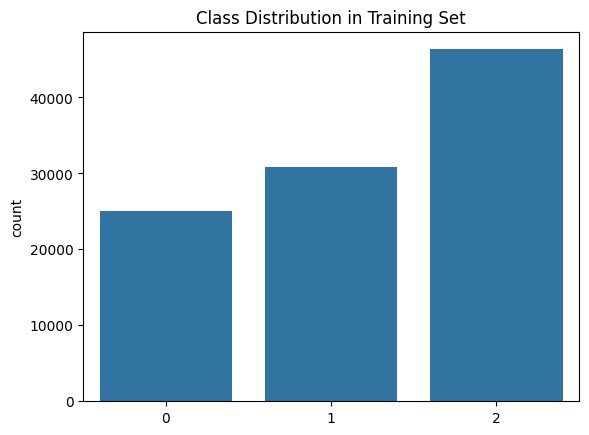

In [2]:
train_data = StoneDataset(root="./dataset/train_val", split="train", transforms=transforms.ToTensor())

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

labels = train_data.labels
sns.countplot(x=labels)
plt.title("Class Distribution in Training Set")

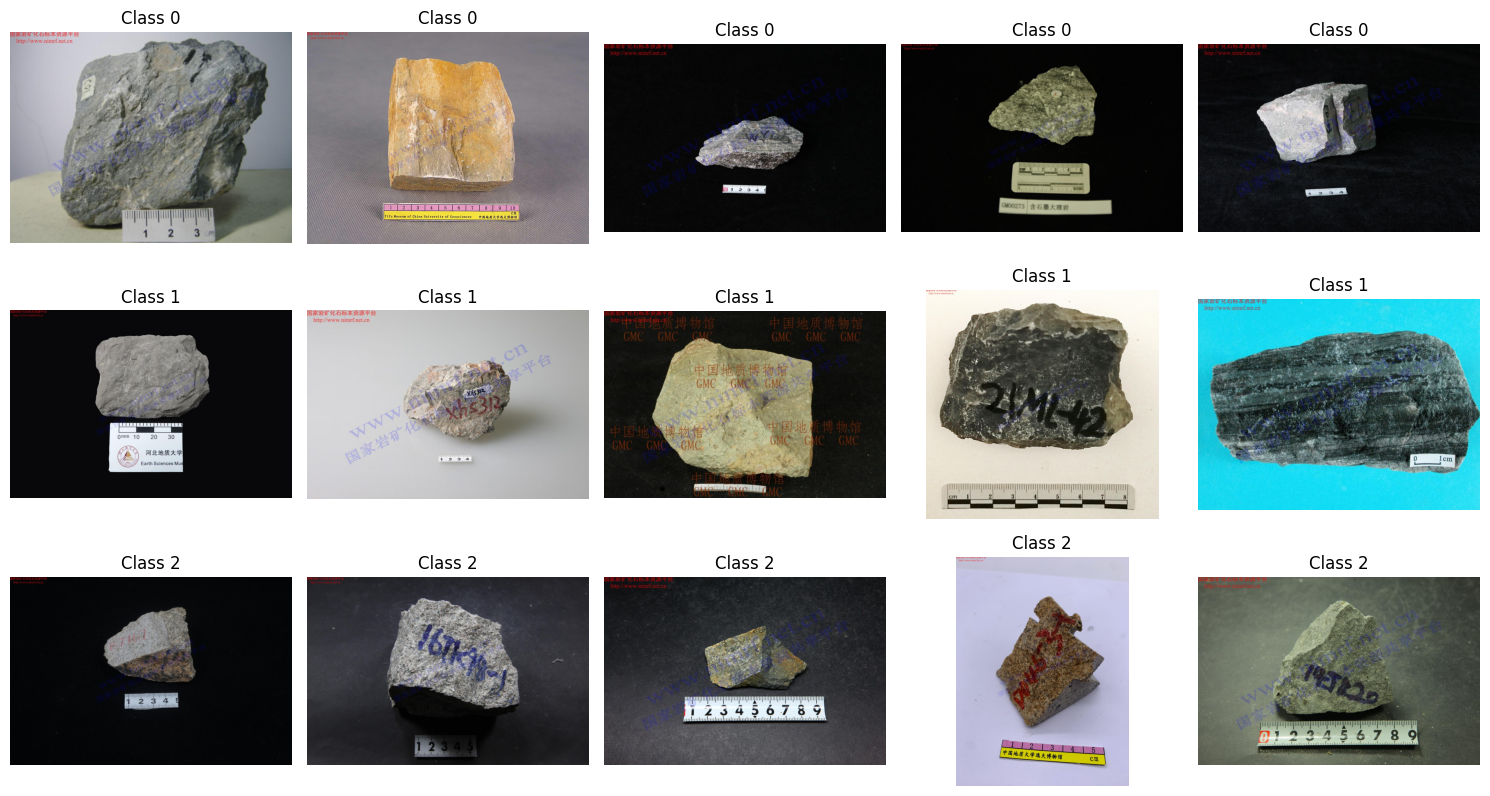

In [3]:
class_indices = {0: [], 1: [], 2: []}
for idx, label in enumerate(train_data.labels):
    class_indices[label].append(idx)

num_samples_per_class = 5
selected_indices = {}
for cls in class_indices:
    if len(class_indices[cls]) >= num_samples_per_class:
        selected_indices[cls] = random.sample(class_indices[cls], num_samples_per_class)
    else:
        selected_indices[cls] = class_indices[cls]

# 直接转换张量为 PIL 图像（无需反归一化）
def tensor_to_pil(tensor):
    return transforms.ToPILImage()(tensor.cpu().clone().squeeze(0))

# 显示图像
fig, axes = plt.subplots(len(selected_indices), num_samples_per_class, figsize=(15, 8))
for cls_idx, cls in enumerate(selected_indices):
    for i, idx in enumerate(selected_indices[cls]):
        img, label = train_data[idx]
        img_pil = tensor_to_pil(img)  # 直接转换
        ax = axes[cls_idx, i]
        ax.imshow(img_pil)
        ax.axis('off')
        ax.set_title(f'Class {cls}')
plt.tight_layout()
plt.show()

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 验证/测试集预处理
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 创建DataLoader
batch_size = 128
train_loader = DataLoader(
    StoneDataset(root="./dataset/train_val", split="train", transforms=train_transform),
    batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    StoneDataset(root="./dataset/train_val", split="val", transforms=val_transform),
    batch_size=batch_size, shuffle=False, num_workers=4
)

In [5]:
from torchvision.models import ViT_B_16_Weights

def build_vit(num_classes=3, pretrained=True):
    weights = ViT_B_16_Weights.DEFAULT if pretrained else None  # 使用 DEFAULT 而不是 IMAGENET21K_V1
    model = vit_b_16(weights=weights)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)
    return model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_labels = train_data.labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    model = model.to(device)
    best_acc = 0.0
    train_losses, val_losses, val_f1,val_accs= [], [], [],[]
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # 验证阶段
        val_loss, val_acc, val_f1_score = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_f1.append(val_f1_score)
        val_accs.append(val_acc)
        
        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%} | Val F1: {val_f1_score:.4f}')  # 新增 F1
    
    history = {'train_loss': train_losses, 'val_loss': val_losses, 'val_acc': val_accs, 'val_f1': val_f1}
    return model, history

In [8]:
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / len(data_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1

In [9]:
model = build_vit(num_classes=3, pretrained=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:17<00:00, 19.6MB/s] 


In [13]:
# 训练模型
# model, history = train_model(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     criterion=criterion,
#     optimizer=optimizer,
#     num_epochs=50
# )

Epoch 1/50 | Train Loss: 0.8834 | Val Loss: 0.8420 | Val Acc: 60.19% | Val F1: 0.6000
Epoch 2/50 | Train Loss: 0.8775 | Val Loss: 0.8348 | Val Acc: 60.35% | Val F1: 0.6024
Epoch 3/50 | Train Loss: 0.8761 | Val Loss: 0.8388 | Val Acc: 60.31% | Val F1: 0.6030
Epoch 4/50 | Train Loss: 0.8696 | Val Loss: 0.8315 | Val Acc: 60.71% | Val F1: 0.6075
Epoch 5/50 | Train Loss: 0.8656 | Val Loss: 0.8244 | Val Acc: 61.11% | Val F1: 0.6095
Epoch 6/50 | Train Loss: 0.8620 | Val Loss: 0.8214 | Val Acc: 61.61% | Val F1: 0.6157
Epoch 7/50 | Train Loss: 0.8589 | Val Loss: 0.8220 | Val Acc: 61.07% | Val F1: 0.6091
Epoch 8/50 | Train Loss: 0.8568 | Val Loss: 0.8235 | Val Acc: 61.42% | Val F1: 0.6145
Epoch 9/50 | Train Loss: 0.8540 | Val Loss: 0.8216 | Val Acc: 61.15% | Val F1: 0.6119
Epoch 10/50 | Train Loss: 0.8500 | Val Loss: 0.8068 | Val Acc: 62.08% | Val F1: 0.6212
Epoch 11/50 | Train Loss: 0.8481 | Val Loss: 0.8060 | Val Acc: 62.31% | Val F1: 0.6229
Epoch 12/50 | Train Loss: 0.8410 | Val Loss: 0.7985 

In [10]:
# 训练模型
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=70
)

Epoch 1/70 | Train Loss: 1.0227 | Val Loss: 0.9222 | Val Acc: 53.70% | Val F1: 0.5233
Epoch 2/70 | Train Loss: 0.9259 | Val Loss: 0.9244 | Val Acc: 55.60% | Val F1: 0.5538
Epoch 3/70 | Train Loss: 0.8996 | Val Loss: 0.8281 | Val Acc: 60.81% | Val F1: 0.6065
Epoch 4/70 | Train Loss: 0.8692 | Val Loss: 0.8298 | Val Acc: 60.63% | Val F1: 0.6024
Epoch 5/70 | Train Loss: 0.8528 | Val Loss: 0.8025 | Val Acc: 62.54% | Val F1: 0.6233
Epoch 6/70 | Train Loss: 0.8359 | Val Loss: 0.7890 | Val Acc: 63.24% | Val F1: 0.6314
Epoch 7/70 | Train Loss: 0.8234 | Val Loss: 0.7696 | Val Acc: 64.47% | Val F1: 0.6442
Epoch 8/70 | Train Loss: 0.8080 | Val Loss: 0.7509 | Val Acc: 65.74% | Val F1: 0.6584
Epoch 9/70 | Train Loss: 0.7969 | Val Loss: 0.7518 | Val Acc: 66.03% | Val F1: 0.6611
Epoch 10/70 | Train Loss: 0.7871 | Val Loss: 0.7561 | Val Acc: 64.71% | Val F1: 0.6469
Epoch 11/70 | Train Loss: 0.7739 | Val Loss: 0.7279 | Val Acc: 67.27% | Val F1: 0.6728
Epoch 12/70 | Train Loss: 0.7658 | Val Loss: 0.7284 

In [11]:
def predict(model, test_loader):
    model.eval()
    filenames = []
    predictions = []
    
    with torch.no_grad():
        for images, paths in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            filenames.extend(list(paths))
            predictions.extend(preds.cpu().numpy())
    
    return filenames, predictions

# 测试集加载
test_loader = DataLoader(
    StoneDataset(root="./dataset/test", split="test", transforms=val_transform),
    batch_size=batch_size, shuffle=False
)

# 生成预测结果
filenames, preds = predict(model, test_loader)

In [15]:
# df = pd.DataFrame({"filename": filenames, "label": preds})
# df.to_csv("submission3.csv", index=False)

In [12]:
df = pd.DataFrame({"filename": filenames, "label": preds})
df.to_csv("submission3new.csv", index=False)

In [18]:
# import matplotlib.pyplot as plt
# def plot_training_log():
#     epochs = list(range(1, 51))  # 共50个epoch

#     train_loss = [
#     0.8834, 0.8775, 0.8761, 0.8696, 0.8656, 0.8620, 0.8589, 0.8568, 0.8540, 0.8500,
#     0.8481, 0.8410, 0.8393, 0.8351, 0.8327, 0.8283, 0.8208, 0.8205, 0.8170, 0.8151,
#     0.8093, 0.8087, 0.8049, 0.7996, 0.7974, 0.7925, 0.7920, 0.7835, 0.7837, 0.7803,
#     0.7788, 0.7726, 0.7686, 0.7689, 0.7644, 0.7606, 0.7582, 0.7549, 0.7541, 0.7493,
#     0.7442, 0.7414, 0.7394, 0.7360, 0.7330, 0.7317, 0.7269, 0.7233, 0.7222, 0.7172
#     ]

#     val_loss = [
#         0.8420, 0.8348, 0.8388, 0.8315, 0.8244, 0.8214, 0.8220, 0.8235, 0.8216, 0.8068,
#         0.8060, 0.7985, 0.7998, 0.8013, 0.8081, 0.7878, 0.7928, 0.7935, 0.7769, 0.7844,
#         0.7830, 0.7706, 0.7685, 0.7829, 0.7730, 0.7765, 0.7575, 0.7598, 0.7626, 0.7570,
#         0.7512, 0.7442, 0.7422, 0.7474, 0.7390, 0.7432, 0.7378, 0.7441, 0.7415, 0.7303,
#         0.7222, 0.7305, 0.7177, 0.7254, 0.7438, 0.7275, 0.7258, 0.7304, 0.7181, 0.7197
#     ]

#     plt.figure(figsize=(12, 7))

#     plt.plot(epochs, train_loss, label='Train Loss', color='black', linewidth=2)
#     plt.plot(epochs, val_loss, label='Val Loss', color='gray', linewidth=2)
#     plt.title('Vit Model Training History')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

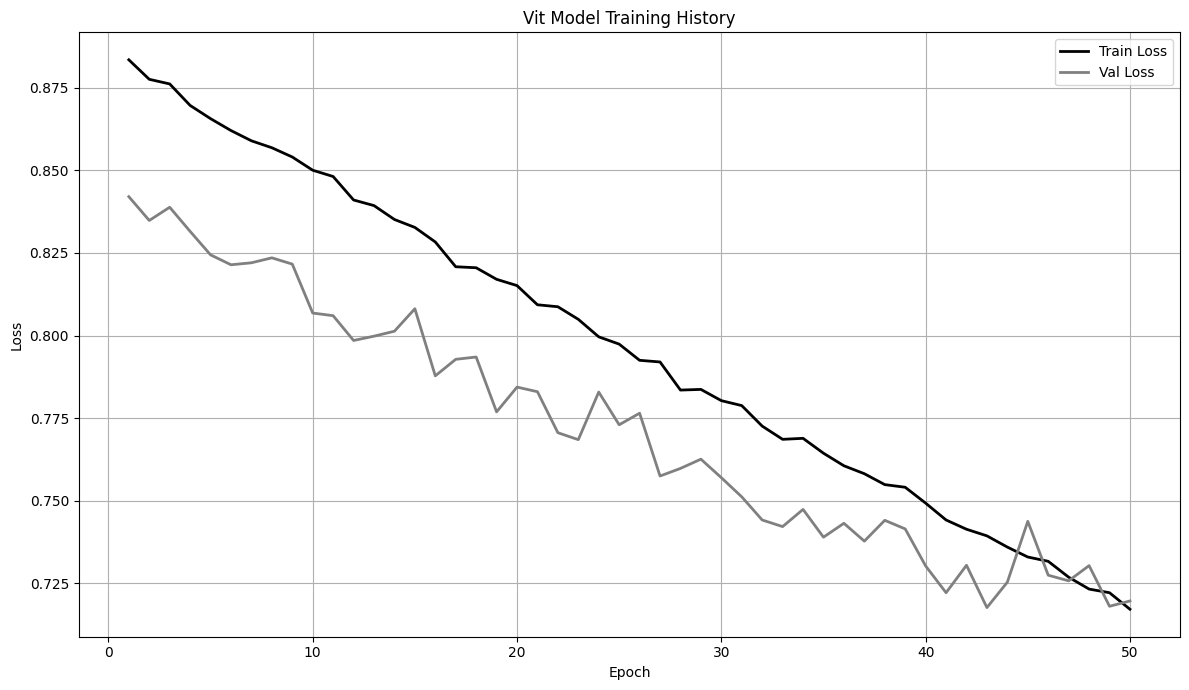

In [19]:
plot_training_log()